In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# triangulation + mess center
def get_iso_pts(poly):
    iso_pts = []
    for triangle in poly:
        adj_point = get_adjacent_points(triangle, poly)
        if len(adj_point) == 1:
            adj_pts = adj_point[0]
            for pts in triangle:
                flag = 0
                for ref_pts in adj_pts:
                    # print(pts)
                    # print(ref_pts)
                    if list(pts) == list(ref_pts):
                        flag = 1
                if flag == 0:
                    iso_pts.append(pts)
    return iso_pts

def get_adjacent_triangle(obj, poly):
    adj_triangle = []
    for triangle in poly:
        num, item = find_same_element(triangle, obj)
        if num == 2:
            adj_triangle.append(triangle)
    return adj_triangle

def draw_mstri(coco, anns, height, width):
    im_list = []
    for i in range(len(anns)):
        bg = np.zeros((height, width))
        mask = coco.annToMask(anns[i])
        x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for s in ct:
            poly = get_hex(s, 10)
            poly = poly.reshape((poly.shape[0], poly.shape[2]))
            if len(poly) == 1:
                x, y = poly[0]
                bg[x-5:x+5,y-5:y+5] == 1
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                continue
            elif len(poly) == 2:
                cv2.polylines(bg, [poly], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                continue
            poly_tri = np.array(earclip(poly))
            if len(poly_tri.shape) != 3:
                continue
            assert(poly_tri.shape[1] == 3)
            assert(poly_tri.shape[2] == 2)
            if len(poly_tri) == 1:
                bg = np.zeros((height, width))
                mc = np.mean(poly_tri[0], axis=0)
                for pts in poly_tri[0]:
                    apex = np.vstack((mc, pts)).astype(int)
                    cv2.polylines(bg, [apex], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            else:
                bg = np.zeros((height, width))
                for i in poly_tri:
                    
                    adj_tri = get_adjacent_triangle(i, poly_tri)
                    mc_i = np.mean(i, axis = 0)
                    for j in adj_tri:
                        mc_j = np.mean(j, axis = 0)
                        apex = np.vstack((mc_i, mc_j)).astype(int)
                        cv2.polylines(bg, [apex], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    t = im_list[0].astype(np.int).flatten()
    for i in range(1,len(im_list)):
        t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
    t = t.reshape((height, width)) 
    return t

def draw_result_mstri(coco, catIds, height, width, color, img, graph):
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    scribble = draw_mstri(coco, anns, height, width)
    for i in range(height):
        for j in range(width):
            if scribble[i, j] == 1:
                graph[i, j] = color
    return graph

# to show example, useless when generating annotation
def draw_sample_mstri(coco, img, img_pos):
    # graph = io.imread(r'/gdrive/My Drive/anno/draw/{}'.format(img['file_name']))
    graph = io.imread(r'{}/{}'.format(img_pos, img['file_name']))
    graph = draw_result_mstri(coco, [1], img['height'], img['width'], [255,0,0], img, graph)
    # graph = draw_result_tri(coco, range(2,91), img['height'], img['width'], [0,255,0], img, graph)
    plt.imshow(graph)
    plt.axis('off')

def create_scribble_anno_mstri(coco, img, target = 1, background_target = 2, real_background = 0):
    graph = np.zeros((img['height'], img['width'])) * real_background
    # add_background = draw_result_tri(coco, range(2,91), img['height'], img['width'], background_target, img, graph)
    # add_target = draw_result_tri(coco, [1], img['height'], img['width'], target, img, add_background)
    add_target = draw_result_mstri(coco, [1], img['height'], img['width'], target, img, graph)
    return add_target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

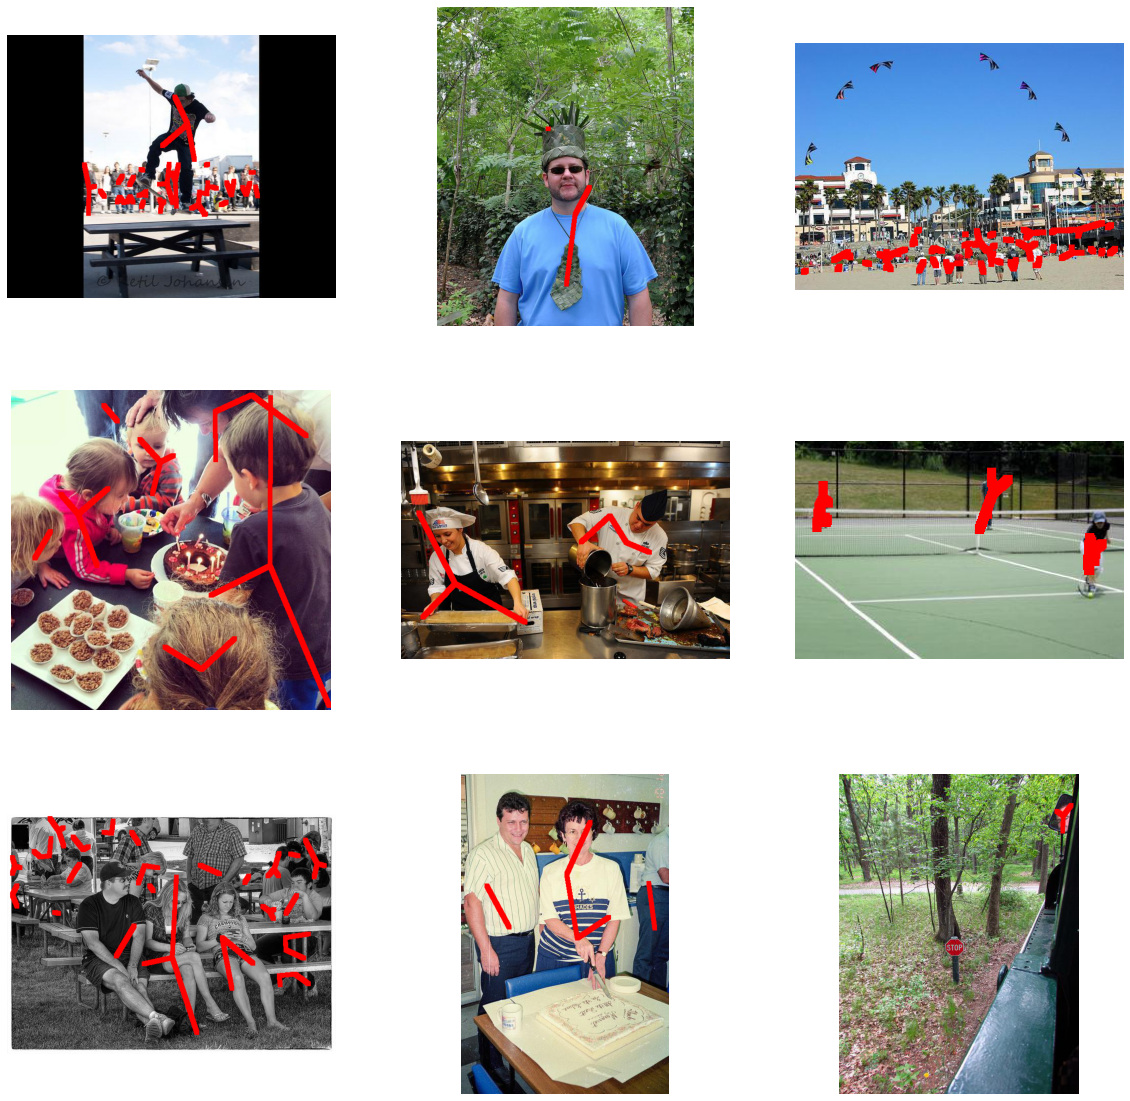

In [ ]:
ori = np.load(r'/gdrive/My Drive/anno/person.npy', allow_pickle=True)
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    draw_sample_mstri(coco_train, ori[i], r'/gdrive/My Drive/anno/draw')

In [ ]:
# above based on triangulation + mess center

# below based on polygon triangulation 

In [ ]:
import math
import sys
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])

EPSILON = math.sqrt(sys.float_info.epsilon)


def earclip(polygon):
    ear_vertex = []
    triangles = []

    polygon = [Point(*point) for point in polygon]

    if _is_clockwise(polygon):
        polygon.reverse()

    point_count = len(polygon)
    for i in range(point_count):
        prev_index = i - 1
        prev_point = polygon[prev_index]
        point = polygon[i]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        if _is_ear(prev_point, point, next_point, polygon):
            ear_vertex.append(point)

    while ear_vertex and point_count >= 3:
        ear = ear_vertex.pop(0)
        i = polygon.index(ear)
        prev_index = i - 1
        prev_point = polygon[prev_index]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        polygon.remove(ear)
        point_count -= 1
        triangles.append(((prev_point.x, prev_point.y), (ear.x, ear.y), (next_point.x, next_point.y)))
        if point_count > 3:
            prev_prev_point = polygon[prev_index - 1]
            next_next_index = (i + 1) % point_count
            next_next_point = polygon[next_next_index]

            groups = [
                (prev_prev_point, prev_point, next_point, polygon),
                (prev_point, next_point, next_next_point, polygon),
            ]
            for group in groups:
                p = group[1]
                if _is_ear(*group):
                    if p not in ear_vertex:
                        ear_vertex.append(p)
                elif p in ear_vertex:
                    ear_vertex.remove(p)
    return triangles


def _is_clockwise(polygon):
    s = 0
    polygon_count = len(polygon)
    for i in range(polygon_count):
        point = polygon[i]
        point2 = polygon[(i + 1) % polygon_count]
        s += (point2.x - point.x) * (point2.y + point.y)
    return s > 0


def _is_convex(prev, point, next):
    return _triangle_sum(prev.x, prev.y, point.x, point.y, next.x, next.y) < 0


def _is_ear(p1, p2, p3, polygon):
    ear = _contains_no_points(p1, p2, p3, polygon) and \
        _is_convex(p1, p2, p3) and \
        _triangle_area(p1.x, p1.y, p2.x, p2.y, p3.x, p3.y) > 0
    return ear


def _contains_no_points(p1, p2, p3, polygon):
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif _is_point_inside(pn, p1, p2, p3):
            return False
    return True


def _is_point_inside(p, a, b, c):
    area = _triangle_area(a.x, a.y, b.x, b.y, c.x, c.y)
    area1 = _triangle_area(p.x, p.y, b.x, b.y, c.x, c.y)
    area2 = _triangle_area(p.x, p.y, a.x, a.y, c.x, c.y)
    area3 = _triangle_area(p.x, p.y, a.x, a.y, b.x, b.y)
    areadiff = abs(area - sum([area1, area2, area3])) < EPSILON
    return areadiff


def _triangle_area(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)


def _triangle_sum(x1, y1, x2, y2, x3, y3):
    return x1 * (y3 - y2) + x2 * (y1 - y3) + x3 * (y2 - y1)



In [ ]:
# def get_ten(s, coef, flag = 0):
#     approx = cv2.approxPolyDP(s, coef, True)
#     edge = len(approx)
#     if edge < 3:
#         if flag == 1:
#             return approx
#         else:
#             return get_ten(s, coef / 2, -1)
#     elif edge > 6:
#         if flag == -1:
#             return approx
#         else:
#             return get_ten(s, coef * 2, 1)
#     else:
#         return approx

def get_hex(s, coef, ct=0):
    approx = cv2.approxPolyDP(s, coef, True)
    edge = len(approx)
    if ct == 500:
        return approx
    if edge > 6:
        return get_hex(s, coef * 2, ct+1)
    elif edge < 3:
        return get_hex(s, coef / 2, ct+1)
    else:
        return approx

def find_same_element(x, y):
    num = 0
    item = []
    for i in x:
        for j in y:
            if list(i) == list(j):
                item.append(i)
                num += 1
    return num, item

def get_adjacent_points(obj, poly):
    adj_point = []
    adj_num = 0
    for triangle in poly:
        num, item = find_same_element(triangle, obj)
        if num == 2:
            adj_num += 1
            adj_point.append(list(item))
    return np.array(adj_point)

def middle_pts(pts):
    assert(len(pts)==2)
    x = 0.5*(pts[0]+pts[1])
    x = x.astype(int)
    return x


def other_pts(pts, triangle):
    assert(len(pts)==2)
    for p1 in triangle:
        flag = 0
        for p2 in pts:
            if list(p1) == list(p2):
                flag = 1
        if flag == 0:
            return p1

def draw_tri(coco, anns, height, width):
    im_list = []
    for i in range(len(anns)):
        bg = np.zeros((height, width))
        mask = coco.annToMask(anns[i])
        x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for s in ct:
            poly = get_hex(s, 10)
            poly = poly.reshape((poly.shape[0], poly.shape[2]))
            if len(poly) == 1:
                x, y = poly[0]
                bg[x-5:x+5,y-5:y+5] == 1
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                continue
            elif len(poly) == 2:
                cv2.polylines(bg, [poly], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                continue
            # print(poly.shape)
            # print(poly)
            poly_tri = np.array(earclip(poly))
            # assert(poly_tri.shape[0] == len(poly) - 2)
            if len(poly_tri.shape) != 3:
                continue
            assert(poly_tri.shape[1] == 3)
            assert(poly_tri.shape[2] == 2)
            if len(poly_tri) == 1:
                bg = np.zeros((height, width))
                adj_point = poly_tri[0]
                # print('adj', adj_point)
                middle_12 = middle_pts(adj_point[:2])
                # print(middle_12)
                # print(adj_point[2])
                len_12 = np.linalg.norm(middle_12 - adj_point[2])
                middle_23 = middle_pts(adj_point[1:])
                len_23 = np.linalg.norm(middle_23 - adj_point[0])
                middle_13 = middle_pts([adj_point[0], adj_point[2]])
                len_13 = np.linalg.norm(middle_13 - adj_point[1])
                lenall = [len_12, len_13, len_23]
                if len_12 == np.max(lenall):
                    apex = np.vstack((middle_12, adj_point[2])).astype(int)
                elif len_23 == np.max(lenall):
                    apex = np.vstack((middle_23, adj_point[0])).astype(int)
                else:
                    apex = np.vstack((middle_13, adj_point[1])).astype(int)
                cv2.polylines(bg, [apex], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            else:
                for i in poly_tri:
                    bg = np.zeros((height, width))
                    adj_point= get_adjacent_points(i,poly_tri)
                    if len(adj_point) == 1:
                        adj_point = adj_point[0]
                        apex = np.vstack((middle_pts(adj_point), other_pts(adj_point, i))).astype(int)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    elif len(adj_point) == 2:
                        apex = np.vstack((middle_pts(adj_point[0]), middle_pts(adj_point[1]))).astype(int)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    else:
                        assert(len(adj_point) == 3)
                        m1 = middle_pts(adj_point[0])
                        m2 = middle_pts(adj_point[1])
                        m3 = middle_pts(adj_point[2])
                        m12 = middle_pts([m1,m2])
                        apex = np.vstack((m1,m2))
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                        apex = np.vstack((m12,m3))
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))

                    # adj_point = get_adjacent_points(triangle, poly_tri)
                    # if len(adj_point) == 2:
                    #     # apex = curve_scribble(np.vstack((middle_pts(adj_point), other_pts(adj_point, triangle))))
                    #     apex = np.vstack((middle_pts(adj_point), other_pts(adj_point, triangle))).astype(int)
                    #     cv2.polylines(bg, [apex], 0, 1)
                    #     im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    # else:
                    #     assert(len(adj_point) == 3)
                    #     middle_12 = middle_pts(adj_point[:2])
                    #     middle_23 = middle_pts(adj_point[1:])
                    #     middle_13 = middle_pts([adj_point[0], adj_point[2]])
                    #     middle_tri = middle_pts([middle_12, middle_23])
                    #     # apex = curve_scribble(np.vstack((middle_12, middle_23)))
                    #     apex = np.vstack((middle_12, middle_23)).astype(int)
                    #     cv2.polylines(bg, [apex], 0, 1)
                    #     im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    #     # apex = curve_scribble(np.vstack((middle_13, middle_tri)))
                    #     apex = np.vstack((middle_13, middle_tri)).astype(int)
                    #     cv2.polylines(bg, [apex], 0, 1)
                    #     im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    t = im_list[0].astype(np.int).flatten()
    for i in range(1,len(im_list)):
        t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
    t = t.reshape((height, width)) 
    return t

def draw_result_tri(coco, catIds, height, width, color, img, graph):
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    scribble = draw_tri(coco, anns, height, width)
    for i in range(height):
        for j in range(width):
            if scribble[i, j] == 1:
                graph[i, j] = color
    return graph

# to show example, useless when generating annotation
def draw_sample_tri(coco, img, img_pos):
    # graph = io.imread(r'/gdrive/My Drive/anno/draw/{}'.format(img['file_name']))
    graph = io.imread(r'{}/{}'.format(img_pos, img['file_name']))
    graph = draw_result_tri(coco, [1], img['height'], img['width'], [255,0,0], img, graph)
    # graph = draw_result_tri(coco, range(2,91), img['height'], img['width'], [0,255,0], img, graph)
    plt.imshow(graph)
    plt.axis('off')

def create_scribble_anno_tri(coco, img, target = 1, background_target = 2, real_background = 0):
    graph = np.zeros((img['height'], img['width'])) * real_background
    # add_background = draw_result_tri(coco, range(2,91), img['height'], img['width'], background_target, img, graph)
    # add_target = draw_result_tri(coco, [1], img['height'], img['width'], target, img, add_background)
    add_target = draw_result_tri(coco, [1], img['height'], img['width'], target, img, graph)
    return add_target

In [ ]:
dataDir = '/gdrive/My Drive/anno'
coco_train = COCO('{}/instances_train2017.json'.format(dataDir))

loading annotations into memory...
Done (t=43.30s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

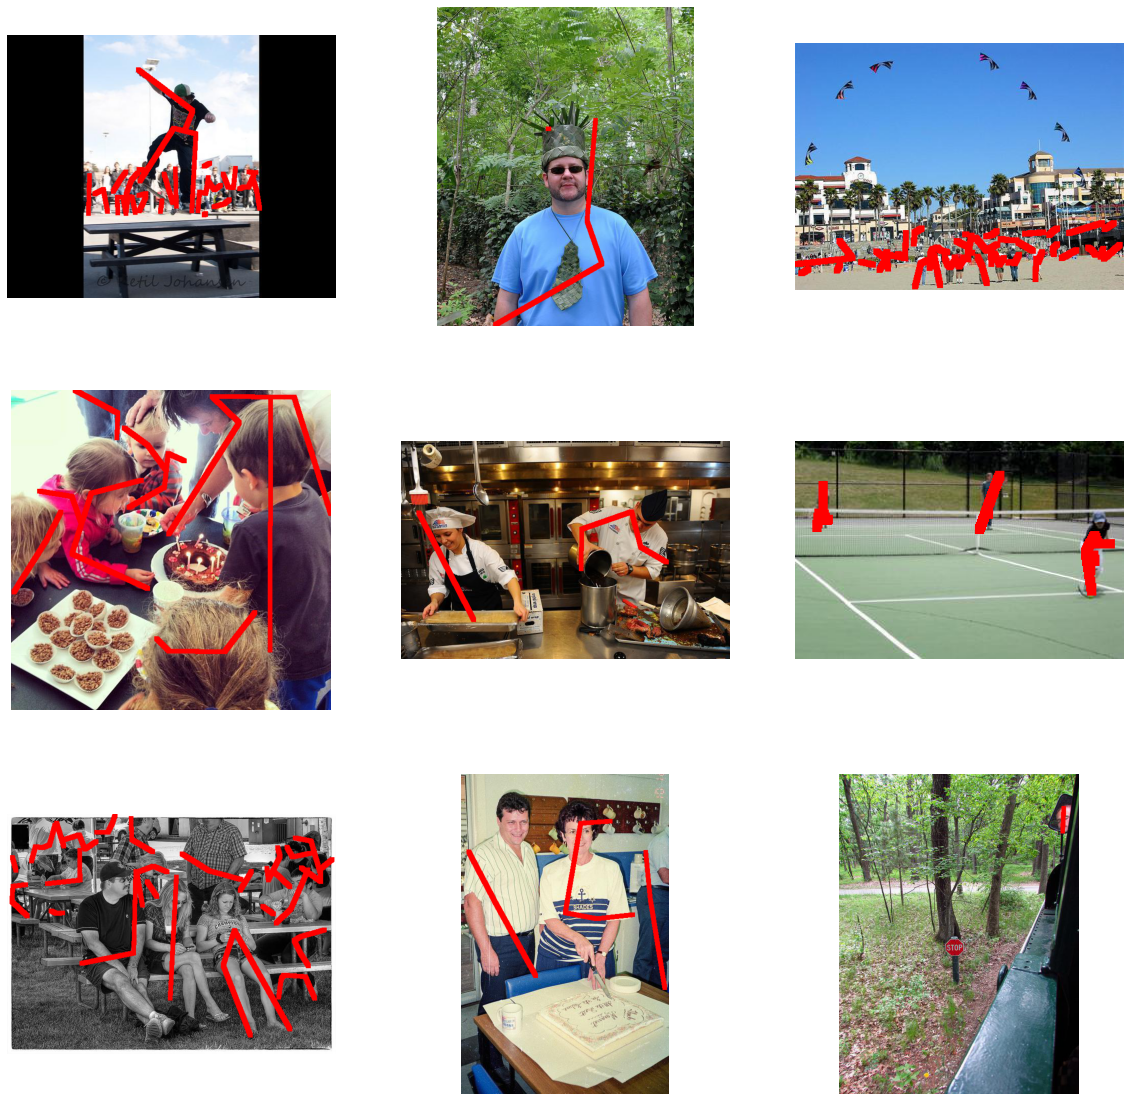

In [ ]:
ori = np.load(r'/gdrive/My Drive/anno/person.npy', allow_pickle=True)
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    draw_sample_tri(coco_train, ori[i], r'/gdrive/My Drive/anno/draw')

In [ ]:
# change line into sin curve

def curve_scribble(pts):
    a1, b1, a2, b2 = pts[0,0], pts[0,1], pts[1,0], pts[1,1]
    x = np.linspace(a1,a2,1000)
    # 1e-7 to avoid 0
    y = (b1-b2)/(a1-a2+1e-7)*(x-a2)+b2
    hypo = np.sqrt((a1-a2)**2+(b1-b2)**2)+1e-7
    i = np.linspace(-hypo/2, hypo/2, 1000)
    # can adjust 10, 33 here to get different curve
    # hypo is the length between pts, 33 is aprox to 10*pi, which is 5 periods curve
    # 10 is amplitude
    j = 10*np.sin(33/hypo*i)
    cos = (a2-a1)/hypo
    sin = (b2-b1)/hypo
    matrix = np.array([[cos,-sin],[sin,cos]])
    z = np.dot(matrix,np.vstack((i,j)))
    anno = np.vstack((z[0]+(a1+a2)/2,z[1]+(b1+b2)/2))
    return anno.T.astype(int)

def draw_tri_s(coco, anns, height, width):
    im_list = []
    for i in range(len(anns)):
        bg = np.zeros((height, width))
        mask = coco.annToMask(anns[i])
        x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for s in ct:
            poly = get_hex(s, 10)
            poly = poly.reshape((poly.shape[0], poly.shape[2]))
            # print(poly.shape)
            # print(poly)
            poly_tri = np.array(earclip(poly))
            # assert(poly_tri.shape[0] == len(poly) - 2)
            if len(poly_tri.shape) != 3:
                continue
            assert(poly_tri.shape[1] == 3)
            assert(poly_tri.shape[2] == 2)
            if len(poly_tri) == 1:
                bg = np.zeros((height, width))
                adj_point = poly_tri[0]
                # print('adj', adj_point)
                middle_12 = middle_pts(adj_point[:2])
                # print(middle_12)
                # print(adj_point[2])
                len_12 = np.linalg.norm(middle_12 - adj_point[2])
                middle_23 = middle_pts(adj_point[1:])
                len_23 = np.linalg.norm(middle_23 - adj_point[0])
                middle_13 = middle_pts([adj_point[0], adj_point[2]])
                len_13 = np.linalg.norm(middle_13 - adj_point[1])
                lenall = [len_12, len_13, len_23]
                if len_12 == np.max(lenall):
                    apex = np.vstack((middle_12, adj_point[2])).astype(int)
                elif len_23 == np.max(lenall):
                    apex = np.vstack((middle_23, adj_point[0])).astype(int)
                else:
                    apex = np.vstack((middle_13, adj_point[1])).astype(int)
                apex = curve_scribble(apex)
                cv2.polylines(bg, [apex], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            else:
                for i in poly_tri:
                    bg = np.zeros((height, width))
                    adj_point= get_adjacent_points(i,poly_tri)
                    if len(adj_point) == 1:
                        adj_point = adj_point[0]
                        apex = np.vstack((middle_pts(adj_point), other_pts(adj_point, i))).astype(int)
                        apex = curve_scribble(apex)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    elif len(adj_point) == 2:
                        apex = np.vstack((middle_pts(adj_point[0]), middle_pts(adj_point[1]))).astype(int)
                        apex = curve_scribble(apex)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    else:
                        assert(len(adj_point) == 3)
                        m1 = middle_pts(adj_point[0])
                        m2 = middle_pts(adj_point[1])
                        m3 = middle_pts(adj_point[2])
                        m12 = middle_pts([m1,m2])
                        apex = np.vstack((m1,m2))
                        apex = curve_scribble(apex)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                        apex = np.vstack((m12,m3))
                        apex = curve_scribble(apex)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    t = im_list[0].astype(np.int).flatten()
    for i in range(1,len(im_list)):
        t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
    t = t.reshape((height, width)) 
    return t

def draw_result_tri_s(coco, catIds, height, width, color, img, graph):
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    scribble = draw_tri_s(coco, anns, height, width)
    for i in range(height):
        for j in range(width):
            if scribble[i, j] == 1:
                graph[i, j] = color
    return graph

# to show example, useless when generating annotation
def draw_sample_tri_s(coco, img, img_pos):
    # graph = io.imread(r'/gdrive/My Drive/anno/draw/{}'.format(img['file_name']))
    graph = io.imread(r'{}/{}'.format(img_pos, img['file_name']))
    graph = draw_result_tri_s(coco, [1], img['height'], img['width'], [255,0,0], img, graph)
    # graph = draw_result_tri(coco, range(2,91), img['height'], img['width'], [0,255,0], img, graph)
    plt.imshow(graph)
    plt.axis('off')

def create_scribble_anno_tri_s(coco, img, target = 1, background_target = 2, real_background = 0):
    graph = np.zeros((img['height'], img['width'])) * real_background
    # add_background = draw_result_tri(coco, range(2,91), img['height'], img['width'], background_target, img, graph)
    # add_target = draw_result_tri(coco, [1], img['height'], img['width'], target, img, add_background)
    add_target = draw_result_tri_s(coco, [1], img['height'], img['width'], target, img, graph)
    return add_target

In [ ]:
# new part end here

In [ ]:
# get line from perfect annotation
def get_line(s, coef):
    approx = cv2.approxPolyDP(s, coef, True)
    edge = len(approx)
    if edge > 2:
        return get_line(s, coef * 2)
    else:
        return approx

# create scribble for each kind of object
def create_scribble(coco, anns, height, width):
    im_list = []
    for i in range(len(anns)):
        bg = np.zeros((height, width))
        mask = coco.annToMask(anns[i])
        x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for s in ct:
            apex = get_line(s, 10)
            cv2.fillPoly(bg, [apex], 1)
            # by changing iterations para here, adjust line thinkness (higher -> thicker)
            im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    t = im_list[0].astype(np.int).flatten()
    for i in range(1,len(im_list)):
        t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
    t = t.reshape((height, width)) 
    return t

# useless function: get thincker line to see more clear
# def create_scribble_show(coco, anns, height, width):
#     im_list = []
#     for i in range(len(anns)):
#         bg = np.zeros((height, width))
#         mask = coco.annToMask(anns[i])
#         x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
#         gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
#         ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
#         ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         for s in ct:
#             apex = get_line(s, 10)
#             cv2.fillPoly(bg, [apex], 1)
#             im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 10))
#     t = im_list[0].astype(np.int).flatten()
#     for i in range(1,len(im_list)):
#         t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
#     t = t.reshape((height, width)) 
#     return t

# draw scribble and add it to graph para (e.g origin image, annotation for one target)
def draw_result(coco, catIds, height, width, color, img, graph):
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    scribble = create_scribble(coco, anns, height, width)
    for i in range(height):
        for j in range(width):
            if scribble[i, j] == 1:
                graph[i, j] = color
    return graph

# to show example, useless when generating annotation
def draw_sample(coco, img, img_pos):
    # graph = io.imread(r'/gdrive/My Drive/anno/draw/{}'.format(img['file_name']))
    graph = io.imread(r'{}/{}'.format(img_pos, img['file_name']))
    graph = draw_result(coco, [1], img['height'], img['width'], [255,0,0], img, graph)
    graph = draw_result(coco, range(2,91), img['height'], img['width'], [0,255,0], img, graph)
    plt.imshow(graph)
    plt.axis('off')

# this is the main function
# add targets together
# target is the value in annotation for human scribble, background_target for bg, real_background for nothing
# there are some overlap between target and bg_target, I always let target overwrite bg_target; if you want otherwise, just switch line assigned add_background and add_target
def create_scribble_anno(coco, img, target = 1, background_target = 2, real_background = 0):
    graph = np.zeros((img['height'], img['width'])) * real_background
    add_background = draw_result(coco, range(2,91), img['height'], img['width'], background_target, img, graph)
    add_target = draw_result(coco, [1], img['height'], img['width'], target, img, add_background)
    return add_target

In [ ]:
# sinosoidal version
# input: pts: two ending points of line version
# output: sinosoidal curve between pts
def curve_scribble(pts):
    a1, b1, a2, b2 = pts[0,0], pts[0,1], pts[1,0], pts[1,1]
    x = np.linspace(a1,a2,1000)
    # 1e-7 to avoid 0
    y = (b1-b2)/(a1-a2+1e-7)*(x-a2)+b2
    hypo = np.sqrt((a1-a2)**2+(b1-b2)**2)+1e-7
    i = np.linspace(-hypo/2, hypo/2, 1000)
    # can adjust 10, 33 here to get different curve
    # hypo is the length between pts, 33 is aprox to 10*pi, which is 5 periods curve
    # 10 is amplitude
    j = 10*np.sin(33/hypo*i)
    cos = (a2-a1)/hypo
    sin = (b2-b1)/hypo
    matrix = np.array([[cos,-sin],[sin,cos]])
    z = np.dot(matrix,np.vstack((i,j)))
    anno = np.vstack((z[0]+(a1+a2)/2,z[1]+(b1+b2)/2))
    return anno.T.astype(int)

def create_scribble_curve(coco, anns, height, width):
    im_list = []
    for i in range(len(anns)):
        bg = np.zeros((height, width))
        mask = coco.annToMask(anns[i])
        x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for s in ct:
            apex = get_line(s, 10)
            if apex.shape[0] == 1:
                apex = np.repeat(apex, 2, axis = 0)
            apex = curve_scribble(apex.reshape(2,2))
            cv2.polylines(bg, [apex], 0, 1)
            im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    t = im_list[0].astype(np.int).flatten()
    for i in range(1,len(im_list)):
        t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
    t = t.reshape((height, width)) 
    return t

def draw_result_sin(coco, catIds, height, width, color, img, graph):
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    scribble = create_scribble_curve(coco, anns, height, width)
    for i in range(height):
        for j in range(width):
            if scribble[i, j] == 1:
                graph[i, j] = color
    return graph

# to show example, useless when generating annotation
def draw_sample_sin(coco, img, img_pos):
    # graph = io.imread(r'/gdrive/My Drive/anno/draw/{}'.format(img['file_name']))
    graph = io.imread(r'{}/{}'.format(img_pos, img['file_name']))
    graph = draw_result_sin(coco, [1], img['height'], img['width'], [255,0,0], img, graph)
    # graph = draw_result_sin(coco, range(2,91), img['height'], img['width'], [0,255,0], img, graph)
    plt.imshow(graph)
    plt.axis('off')

def create_scribble_anno_sin(coco, img, target = 1, background_target = 2, real_background = 0):
    graph = np.zeros((img['height'], img['width'])) * real_background
    # add_background = draw_result_sin(coco, range(2,91), img['height'], img['width'], background_target, img, graph)
    # add_target = draw_result_sin(coco, [1], img['height'], img['width'], target, img, add_background)
    add_target = draw_result_sin(coco, [1], img['height'], img['width'], target, img, graph)
    return add_target

In [ ]:
# using sample

# create coco dataset
dataDir = '/gdrive/My Drive/anno'
coco_train = COCO('{}/instances_train2017.json'.format(dataDir)) 
# load used image list 
# not sure how you load it; l is a list of coco img dictionary
l = np.load(r'/gdrive/My Drive/anno/person.npy', allow_pickle=True)
# x is generated scribble annotation
# input: coco dataset, image dictionary, values for target, background_target(objects labelled not as person), background(nothing, real background)
x = create_scribble_anno(coco_train, l[0], 1, 2, 0)

In [ ]:
dataDir = '/gdrive/My Drive/anno'
coco_train = COCO('{}/instances_train2017.json'.format(dataDir))

loading annotations into memory...
Done (t=28.66s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

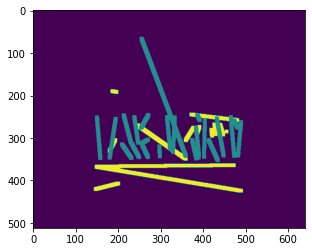

In [ ]:
ori = np.load(r'/gdrive/My Drive/anno/person.npy', allow_pickle=True)
x = create_scribble_anno(coco_train, ori[0], 1, 2, 0)
plt.imshow(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

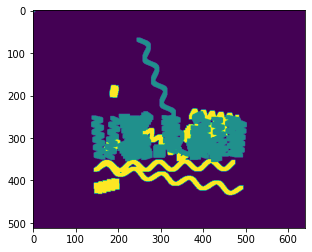

In [ ]:
x = create_scribble_anno_sin(coco_train, ori[0], 1, 2, 0)
plt.imshow(x)

In [ ]:
print(ori[0])

{'license': 1, 'file_name': '000000262148.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000262148.jpg', 'height': 512, 'width': 640, 'date_captured': '2013-11-20 05:50:03', 'flickr_url': 'http://farm5.staticflickr.com/4028/4549977479_547e6b22ae_z.jpg', 'id': 262148}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

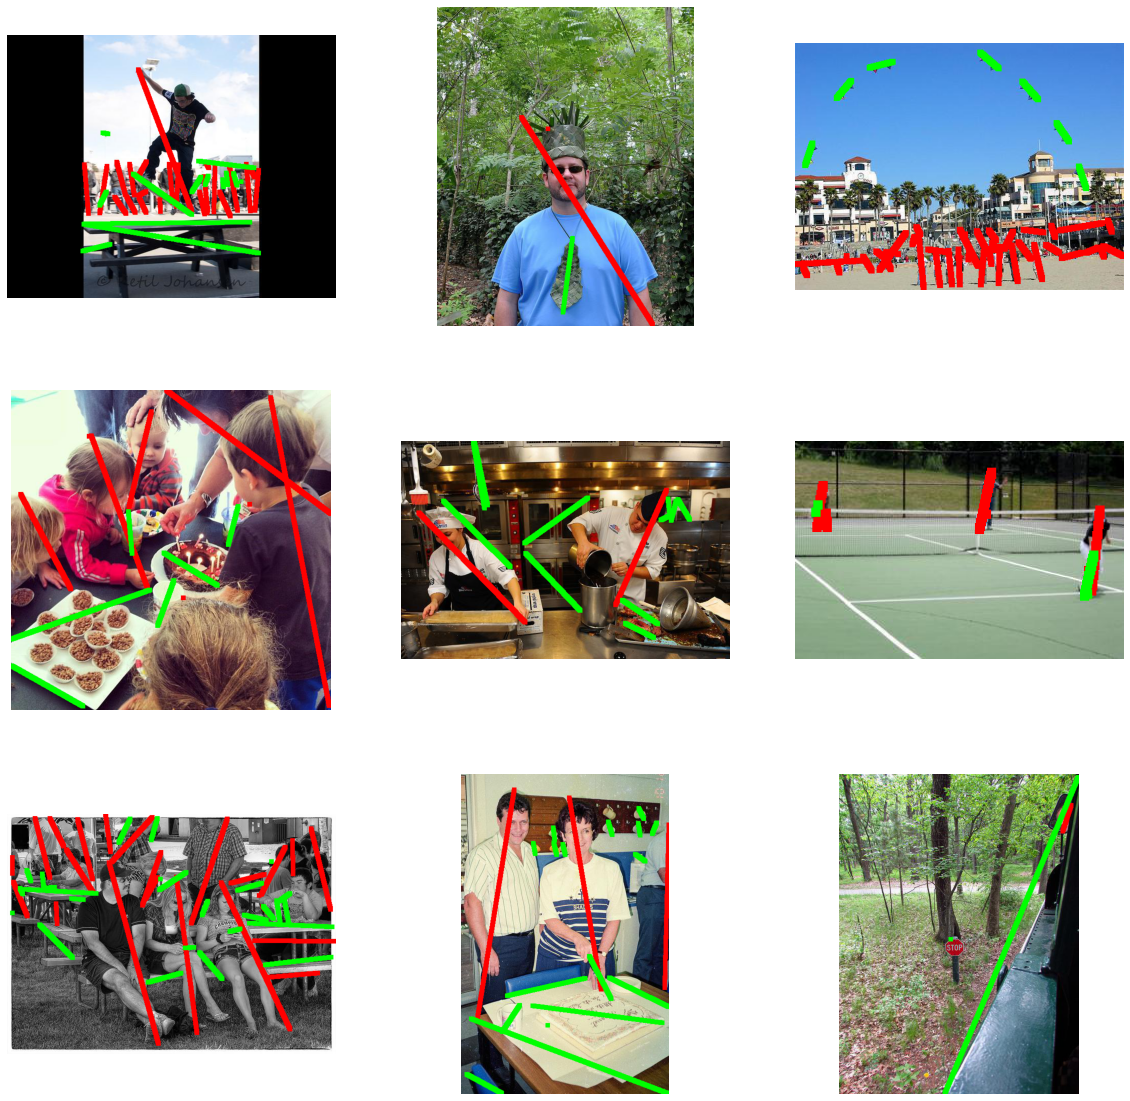

In [ ]:
# samples of generated scribble
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    draw_sample(coco_train, ori[i], r'/gdrive/My Drive/anno/draw')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

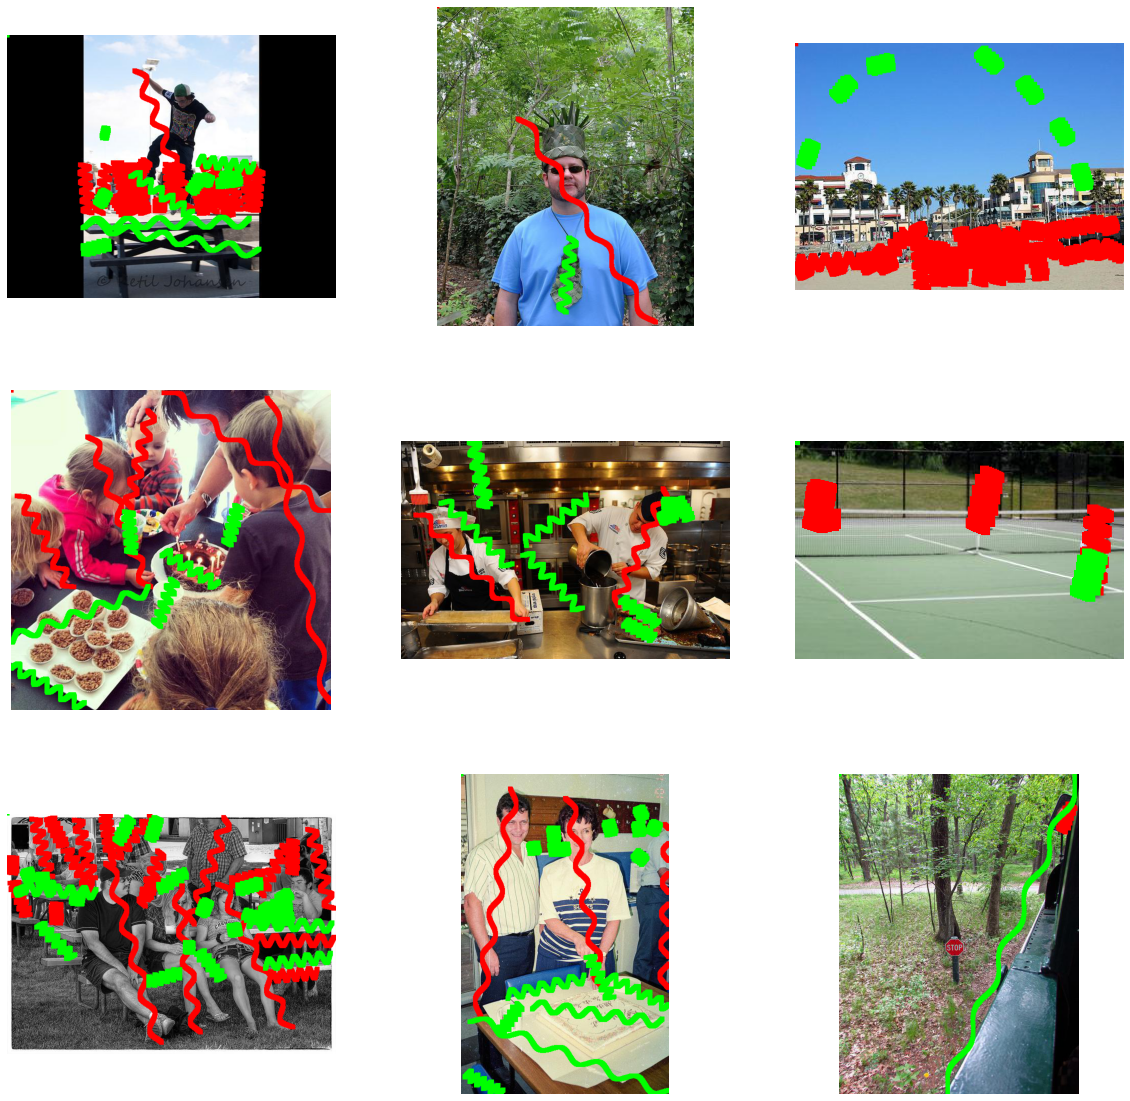

In [ ]:
# samples of generated scribble
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    draw_sample_sin(coco_train, ori[i], r'/gdrive/My Drive/anno/draw')

In [ ]:
def get_polyline(s, coef):
    approx = cv2.approxPolyDP(s, coef, True)
    edge = len(approx)
    if edge > 4:
        return get_polyline(s, coef * 2)
    else:
        return approx

def create_scribble_midline(coco, anns, height, width):
    im_list = []
    for i in range(len(anns)):
        bg = np.zeros((height, width))
        mask = coco.annToMask(anns[i])
        x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
        ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for s in ct:
            apex = get_polyline(s, 1)
            if apex.shape[0] == 1:
                apex = np.repeat(apex, 2, axis = 0)
            if apex.shape[0] == 1 or apex.shape[0] == 2:
                apex = curve_scribble(apex.reshape(2,2))
                cv2.polylines(bg, [apex], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            elif apex.shape[0] == 3:
                apex_poly = apex.reshape(3,2)
                apex_midline = curve_scribble(np.vstack((apex_poly[0], 0.5*(apex_poly[1]+apex_poly[2]))))
                cv2.polylines(bg, [apex_midline], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            else:
                assert(apex.shape[0] == 4)
                apex_poly = apex.reshape(4,2)

                p1 = 0.5*(apex_poly[0]+apex_poly[1])
                p2 = 0.5*(apex_poly[1]+apex_poly[2])
                p3 = 0.5*(apex_poly[2]+apex_poly[3])
                p4 = 0.5*(apex_poly[3]+apex_poly[0])
                d1 = np.linalg.norm(p3-p1)
                d2 = np.linalg.norm(p2-p4)
                if d1 > d2:
                    apex_midline = curve_scribble(np.vstack((p1, p3)))
                else:
                    apex_midline = curve_scribble(np.vstack((p2, p4)))
                cv2.polylines(bg, [apex_midline], 0, 1)
                im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    t = im_list[0].astype(np.int).flatten()
    for i in range(1,len(im_list)):
        t = np.bitwise_or(t, im_list[i].astype(np.int).flatten())
    t = t.reshape((height, width)) 
    return t
    
def draw_result_midline(coco, catIds, height, width, color, img, graph):
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    scribble = create_scribble_midline(coco, anns, height, width)
    for i in range(height):
        for j in range(width):
            if scribble[i, j] == 1:
                graph[i, j] = color
    return graph

# to show example, useless when generating annotation
def draw_sample_midline(coco, img, img_pos):
    # graph = io.imread(r'/gdrive/My Drive/anno/draw/{}'.format(img['file_name']))
    graph = io.imread(r'{}/{}'.format(img_pos, img['file_name']))
    graph = draw_result_midline(coco, [1], img['height'], img['width'], [255,0,0], img, graph)
    # graph = draw_result_midline(coco, range(2,91), img['height'], img['width'], [0,255,0], img, graph)
    plt.imshow(graph)
    plt.axis('off')

def create_scribble_anno_midline(coco, img, target = 1, background_target = 2, real_background = 0):
    graph = np.zeros((img['height'], img['width'])) * real_background
    # add_background = draw_result_midline(coco, range(2,91), img['height'], img['width'], background_target, img, graph)
    add_target = draw_result_midline(coco, [1], img['height'], img['width'], target, img, graph)
    return add_target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

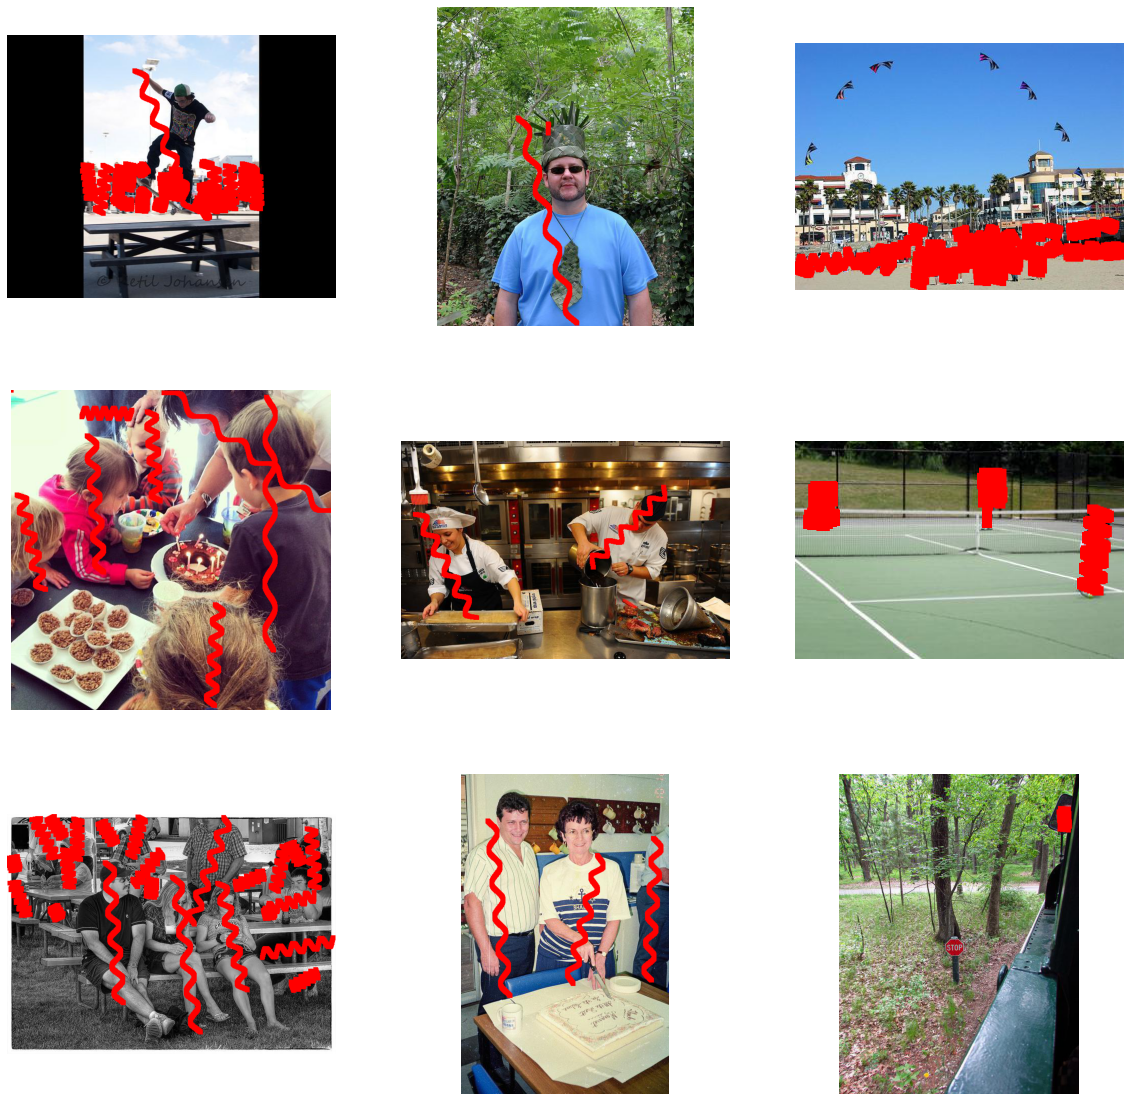

In [ ]:
# samples of generated scribble
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    draw_sample_midline(coco_train, ori[i], r'/gdrive/My Drive/anno/draw')